In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)  # this is needed since the combined df has ~400 cols

In [221]:
train = pd.read_csv('./Data/train_lonlat_id_CS_0521_feature.csv')
test = pd.read_csv('./Data/test_lonlat_id_CS_0521_feature.csv')
macro = pd.read_csv('./Data/macro_feature_CS_0521.csv')
id_test = test.id
try:
    f_imp  = pd.read_csv('./feature_importance.csv')
    f_good = pd.read_csv('./out/feature_pool_dict_8.csv',header=None)
except:
    pass

In [222]:
# we will divide the train set into 5 equal parts, the first 4/5 will be used as train, while the last 1/5 as test
sep_seg = train.shape[0]/10 # divide the train data set into 10 segments (ordered with time)

# everytime we choose 4 as train and 1 as test
i=5  # choose between 0 and 5
sep_start = sep_seg*i
sep_loc   = sep_seg*(i+4)
sep_end   = sep_seg*(i+5)

In [223]:
print sep_start
print sep_loc
print sep_end
print train.shape

15235
27423
30470
(30471, 323)


In [224]:


y_train = train.loc[sep_start:sep_loc,'unit_price']

# y_train = np.log1p(train["price_doc"]) # log1p transformation may hurt performance
y_train = train.loc[sep_start:sep_loc,'unit_price']
y_train.loc[y_train.isnull()]=y_train.median()

x_train = train.loc[sep_start:sep_loc,:].drop(["id", "price_doc","unit_price","log_price_doc","full_sq"], axis=1)
x_test = train.loc[sep_loc+1:sep_end,:].drop(["id","price_doc","unit_price","log_price_doc","full_sq"], axis=1)

In [225]:
print x_train.shape
print x_test.shape

(12189, 318)
(3047, 318)


In [226]:
# num_train = len(train)
df_all = pd.concat([x_train,x_test])

In [227]:
# print df_all.shape
# print train.shape

In [228]:
# change ID variable to categorical variables
IDs = ['ID_big_road1','ID_big_road2',
        'ID_bus_terminal','ID_metro',
       'ID_railroad_station_avto',
       'ID_railroad_station_walk',
       'ID_railroad_terminal']

# def to_object(ID,df):
#     df[ID] = df[ID].astype(object)
#     return(df)

# df_all=to_object(IDs,df_all)

df_all = df_all.drop(IDs, axis=1)

In [229]:
matchers = ['1000','1500','2000','2500','3000','3500','4000','4500','5000']
matching = [s for s in df_all.columns.tolist() if any(xs in s for xs in matchers)]
df_all = df_all.drop(matching, axis=1)

In [230]:
matchers = ['raion']
matching = [s for s in df_all.columns.tolist() if any(xs in s for xs in matchers)]
# matching
df_all = df_all.drop(matching, axis=1)

In [231]:
matchers = ['male','female']
matching = [s for s in df_all.columns.tolist() if any(xs in s for xs in matchers)]
# matching
df_all = df_all.drop(matching, axis=1)

In [232]:
for c in df_all.columns:
    if df_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_all[c].values)) 
        df_all[c] = lbl.transform(list(df_all[c].values))

In [233]:
df_all=df_all.drop(['timestamp'],axis =1 )

In [234]:
# df_all = df_all[f_good[0]]

In [235]:
df_all.shape

(15236, 151)

In [236]:
# x_train = df_all.iloc[:num_train,:]
# x_test = df_all.iloc[num_train:,:]

# print('x_train shape',x_train.shape)
# print('x_test shape',x_test.shape)
# print('y_train shape',y_train.shape)

In [237]:
# f

In [238]:
x_train = df_all.loc[sep_start:sep_loc,:]
x_test = df_all.loc[sep_loc+1:sep_end,:]

print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)
print('y_train shape',y_train.shape)

('x_train shape', (12189, 151))
('x_test shape', (3047, 151))
('y_train shape', (12189,))


In [239]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

[0]	train-rmse:146563	test-rmse:146574
[50]	train-rmse:65225.9	test-rmse:66431.6
[100]	train-rmse:42312.7	test-rmse:45515.7
[150]	train-rmse:36674.1	test-rmse:41486.1
[200]	train-rmse:34703.4	test-rmse:40722.7
[250]	train-rmse:33542	test-rmse:40498.9
[300]	train-rmse:32572.7	test-rmse:40370.2
[350]	train-rmse:31714.6	test-rmse:40285.8
[400]	train-rmse:30906.5	test-rmse:40250.8
CPU times: user 1min 15s, sys: 5.33 s, total: 1min 20s
Wall time: 13.6 s


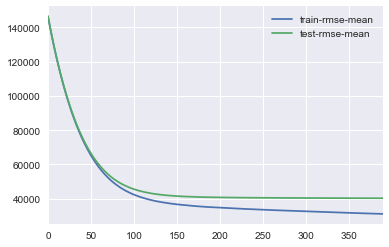

In [240]:
%%time
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [241]:
%%time
num_boost_rounds = len(cv_output)
print(num_boost_rounds)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

390
CPU times: user 34.7 s, sys: 1.83 s, total: 36.5 s
Wall time: 6.08 s


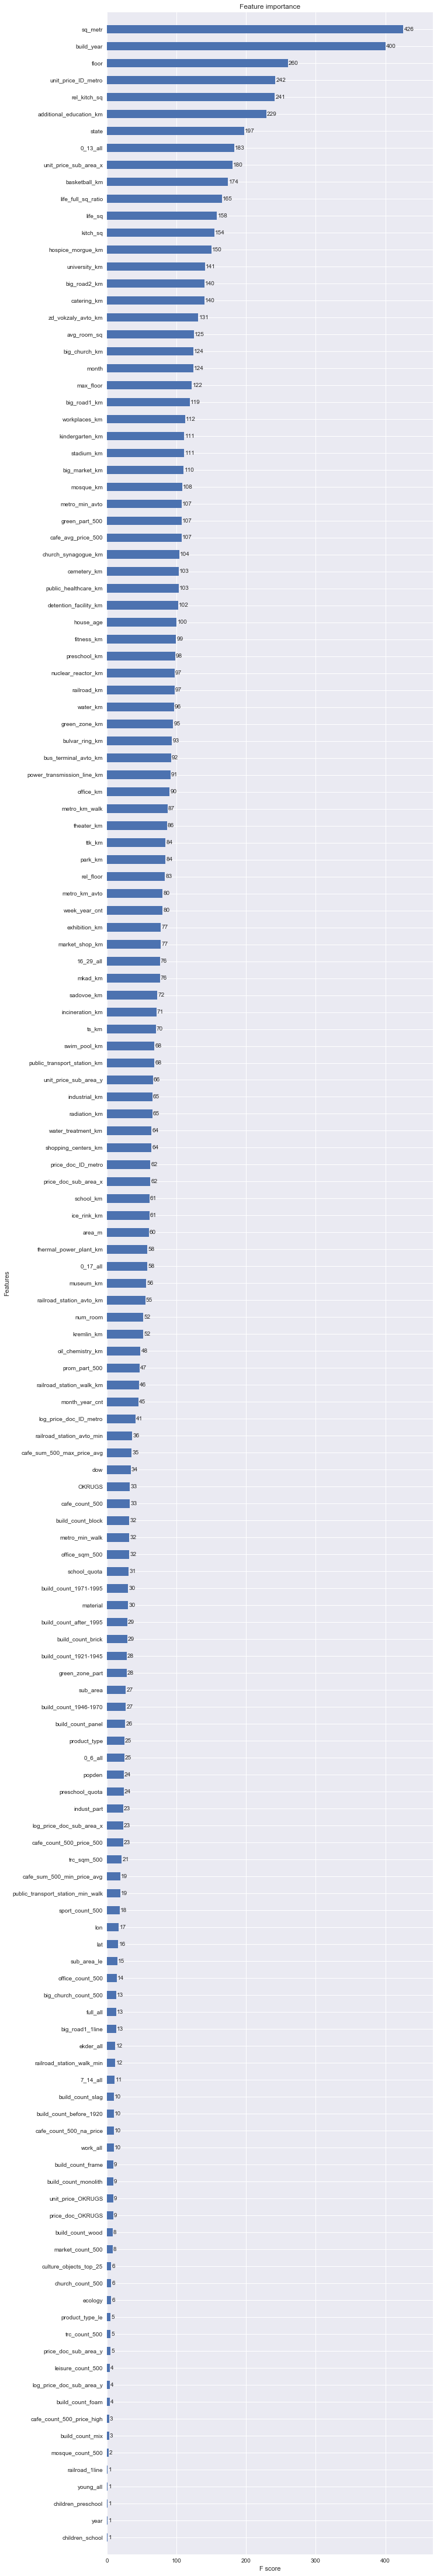

In [242]:
fig, ax = plt.subplots(1, 1, figsize=(10, 80))
xgb.plot_importance(model,\
#                     max_num_features=50, \
                    height=0.5, ax=ax)

In [243]:
importance = model.get_fscore()
importance = pd.DataFrame(sorted(importance.items()),columns =['feature','fscore'])
importance = importance.sort_values(by='fscore',ascending=False).reset_index(drop=True)
importance_features = list(importance.loc[:,'feature'])
importance_features


['sq_metr',
 'build_year',
 'floor',
 'unit_price_ID_metro',
 'rel_kitch_sq',
 'additional_education_km',
 'state',
 '0_13_all',
 'unit_price_sub_area_x',
 'basketball_km',
 'life_full_sq_ratio',
 'life_sq',
 'kitch_sq',
 'hospice_morgue_km',
 'university_km',
 'big_road2_km',
 'catering_km',
 'zd_vokzaly_avto_km',
 'avg_room_sq',
 'big_church_km',
 'month',
 'max_floor',
 'big_road1_km',
 'workplaces_km',
 'stadium_km',
 'kindergarten_km',
 'big_market_km',
 'mosque_km',
 'cafe_avg_price_500',
 'green_part_500',
 'metro_min_avto',
 'church_synagogue_km',
 'cemetery_km',
 'public_healthcare_km',
 'detention_facility_km',
 'house_age',
 'fitness_km',
 'preschool_km',
 'railroad_km',
 'nuclear_reactor_km',
 'water_km',
 'green_zone_km',
 'bulvar_ring_km',
 'bus_terminal_avto_km',
 'power_transmission_line_km',
 'office_km',
 'metro_km_walk',
 'theater_km',
 'ttk_km',
 'park_km',
 'rel_floor',
 'metro_km_avto',
 'week_year_cnt',
 'market_shop_km',
 'exhibition_km',
 'mkad_km',
 '16_29_all

In [244]:
# test.loc[test.sq_metr.isnull(),'sq_metr'] = test.sq_metr.median()
# test.loc[test.sq_metr.isnull(),'sq_metr']

In [245]:
test_2 = train.loc[sep_loc+1:sep_end,:]

test_2.loc[test_2.sq_metr.isnull(),'sq_metr'] = test_2.sq_metr.median()
test_2.loc[test_2.sq_metr.isnull(),'sq_metr']

Series([], Name: sq_metr, dtype: float64)

In [246]:
test_2.shape

(3047, 323)

In [247]:
# y_predict = model.predict(dtest)*test.sq_metr
y_predict = model.predict(dtest)*test_2.sq_metr

In [248]:
y_predict.shape

(3047,)

In [249]:
y_predict.head()

27424    2.274173e+07
27425    8.366855e+06
27426    6.696038e+06
27427    5.769428e+06
27428    4.672241e+06
Name: sq_metr, dtype: float64

In [250]:
y_real = train.loc[sep_loc+1:sep_end,'price_doc']
y_real.head()

27424    30702000.0
27425     8504322.0
27426     6297590.0
27427     6750000.0
27428     5490168.0
Name: price_doc, dtype: float64

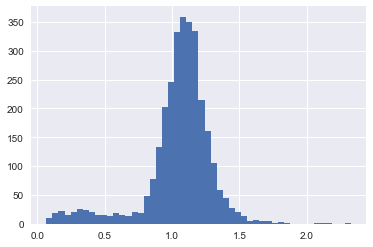

In [251]:
(y_real/y_predict).hist(bins=50)

In [252]:
(y_real/y_predict).mean()

1.0481305255757487

In [253]:
# alpha = 0.2
# # print x_test.loc[y_real/y_predict<0.1,:]
# print y_real.loc[y_real/y_predict<alpha]
# print y_predict.loc[y_real/y_predict<alpha]

In [183]:
# # y_predict = model.predict(dtest)
# y_predict = model.predict(dtest)*test.sq_metr
# # y_predict = np.exp(y_predict) - 1
# df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
# df_sub.to_csv('./sub_test_time_predict.csv', index=False)


In [184]:
# importance.to_csv('./feature_importance.csv')